In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

# 엑셀 파일 로드
xlsx = pd.ExcelFile('/content/drive/MyDrive/확률통계론_프로젝트/simulation/ORG_SETs.xlsx')

'''
sheet_id = "111HeX0oTfrZ7gNsAuyOJnrfOcrZsutrzbhpTUQqtE_A"
sheet_name = []
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(url)

'''

# adjusted return 저장용 딕셔너리
adjusted_returns = {}

# SET1~SET10 중 유효한 시트만 추출
for sheet_name in xlsx.sheet_names:
    if sheet_name.startswith("SET") and "존버" not in sheet_name:
        df = xlsx.parse(sheet_name)
        # 열 이름이 정확히 "total money"와 "labor"인지 확인
        if "total money" in df.columns and "labor" in df.columns:
            total_money = df["total money"]
            labor = df["labor"]
            with pd.option_context('mode.use_inf_as_na', True):
                ret = (total_money - labor) / labor
            adjusted_returns[sheet_name] = ret

# 데이터프레임으로 통합
adj_returns_df = pd.DataFrame(adjusted_returns)

# 수익률의 평균과 분산 계산
summary = pd.DataFrame({
    "mean": adj_returns_df.mean(),
    "variance": adj_returns_df.var()
})

# 결과 확인
print(summary)


            mean  variance
SET1    0.323377  0.068045
SET2    0.092564  0.000980
SET3    0.602890  0.044749
SET4    0.366233  0.006406
SET5    0.470577  0.007571
SET6    0.396643  0.038077
SET7    0.543584  0.030600
SET8   -0.183266  0.046077
SET_9   0.631253  0.052846
SET_10  0.660484  0.027896


/tmp/ipython-input-3-752153190.py:26: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipython-input-3-752153190.py:26: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipython-input-3-752153190.py:26: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipython-input-3-752153190.py:26: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipython-input-3-752153190.py:26: FutureWarning: use_inf

## 모수 추정

In [ ]:
# Sharpe ratio 계산 (risk-free rate = 0 가정)
summary["sharpe_ratio"] = summary["mean"] / np.sqrt(summary["variance"])

# Sharpe Ratio 기준 내림차순 정렬
sharpe_sorted = summary.sort_values("sharpe_ratio", ascending=False)

sharpe_sorted

,mean,variance,sharpe_ratio
SET5,0.470577,0.007571,5.408349
SET4,0.366233,0.006406,4.575937
SET_10,0.660484,0.027896,3.954498
SET7,0.543584,0.030600,3.107439
SET2,0.092564,0.000980,2.957221
SET3,0.602890,0.044749,2.850025
SET_9,0.631253,0.052846,2.745990
SET6,0.396643,0.038077,2.032685
SET1,0.323377,0.068045,1.239687
SET8,-0.183266,0.046077,-0.853765


- SET5와 SET4는 높은 안정성과 중간 이상의 수익률 → 가장 효율적인 전략

- SET_10은 수익률이 가장 높지만, 리스크도 상대적으로 큼

## 상위 3 전략 시각화

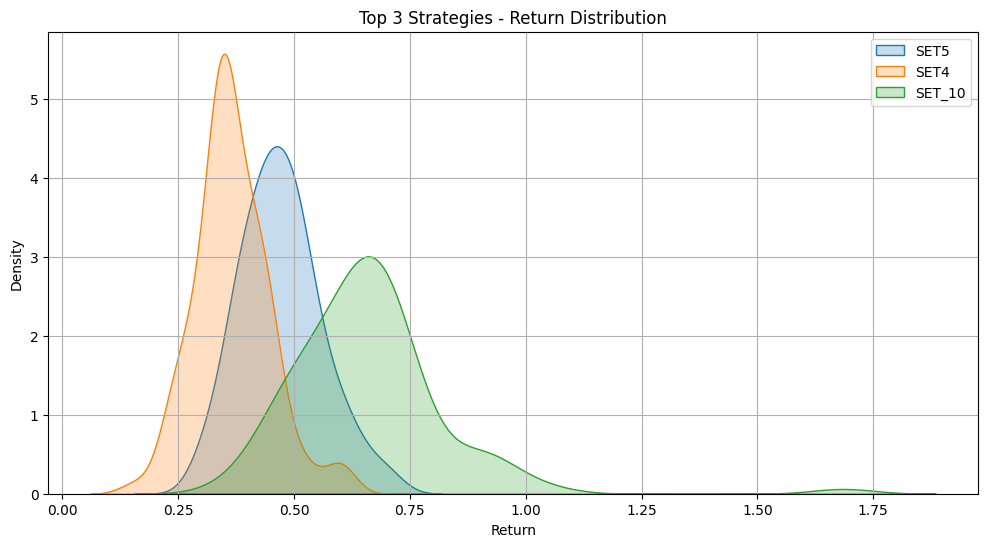

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

top_sets = ["SET5", "SET4", "SET_10"]
plt.figure(figsize=(12, 6))

for set_name in top_sets:
    sns.kdeplot(adj_returns_df[set_name], label=set_name, fill=True)

plt.title("Top 3 Strategies - Return Distribution")
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


## 정규성 검정

In [ ]:
from scipy.stats import shapiro

# 정규성 검정을 수행할 SET 목록
sets_to_test = ["SET5", "SET4", "SET_10", "SET8"]

# 결과 저장
normality_results = {}

for set_name in sets_to_test:
    data = pd.to_numeric(adj_returns_df[set_name], errors="coerce").dropna()
    stat, p_value = shapiro(data)
    normality_results[set_name] = {
        "W-statistic": stat,
        "p-value": p_value,
        "normality": "Reject H0 (Not Normal)" if p_value < 0.05 else "Fail to Reject H0 (Normal)"
    }

# 결과를 데이터프레임으로 정리
normality_df = pd.DataFrame(normality_results).T
normality_df

,W-statistic,p-value,normality
SET5,0.985059,0.320736,Fail to Reject H0 (Normal)
SET4,0.969553,0.020433,Reject H0 (Not Normal)
SET_10,0.828432,0.0,Reject H0 (Not Normal)
SET8,0.967303,0.013794,Reject H0 (Not Normal)


SET5만 유일하게 정규성을 만족한다고 볼 수 있다

In [ ]:
from scipy.stats import expon, weibull_min, gamma

# 비정규성 판별된 SET (SET4, SET_10, SET8)
non_normal_sets = ["SET4", "SET_10", "SET8"]
fit_results = {}

# 피팅 함수
def fit_distribution(data):
    results = {}
    data = pd.to_numeric(data, errors="coerce").dropna()
    data = data[np.isfinite(data)]

    # Exponential
    exp_params = expon.fit(data)
    results["Exponential"] = exp_params

    # Weibull
    weibull_params = weibull_min.fit(data)
    results["Weibull"] = weibull_params

    # Gamma
    gamma_params = gamma.fit(data)
    results["Gamma"] = gamma_params

    return results

# 모든 대상 SET에 대해 피팅
for set_name in non_normal_sets:
    series = adj_returns_df[set_name]
    fit_results[set_name] = fit_distribution(series)

fit_results

{'SET4': {'Exponential': (0.15606039454512685, 0.21017258803955072),
  'Weibull': (np.float64(2.185110578190777),
   np.float64(0.20642374450053047),
   np.float64(0.1820163184420628)),
  'Gamma': (np.float64(38.6326204194782),
   np.float64(-0.12621323630042425),
   np.float64(0.012746901789159278))},
 'SET_10': {'Exponential': (0.3535130687212645, 0.30697083840741407),
  'Weibull': (np.float64(0.8876637831437169),
   np.float64(0.3535130687212644),
   np.float64(0.22979475034680108)),
  'Gamma': (np.float64(6.216753078961304),
   np.float64(0.27862968832719104),
   np.float64(0.061423413886566275))},
 'SET8': {'Exponential': (-0.5316358146730426, 0.3483696893098238),
  'Weibull': (np.float64(1.817096573795957),
   np.float64(-0.5626001556700218),
   np.float64(0.4259405851320195)),
  'Gamma': (np.float64(4.624145115876031),
   np.float64(-0.6581394016888236),
   np.float64(0.10269423793145839))}}

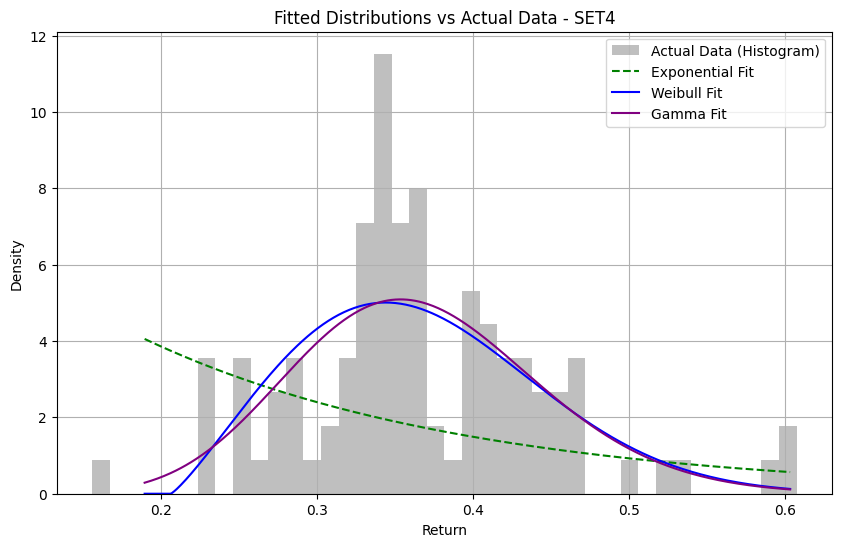

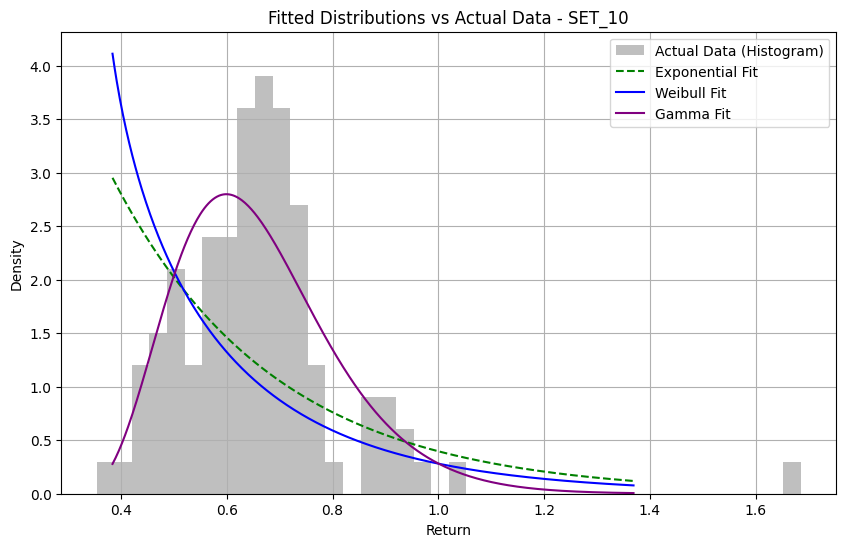

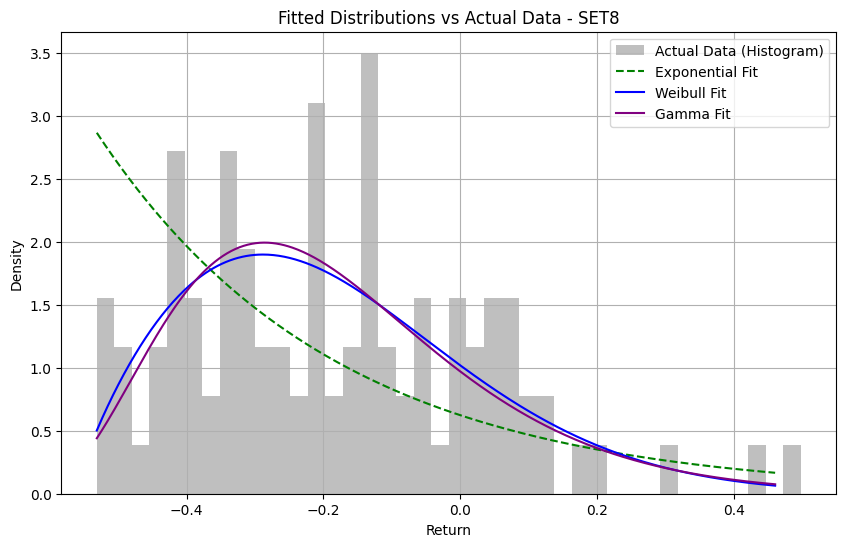

In [ ]:

def plot_fitted_distributions(set_name, params_dict):
    data = pd.to_numeric(adj_returns_df[set_name], errors="coerce").dropna()
    data = data[np.isfinite(data)]

    # X축 범위를 중앙 99% 범위로 제한
    x = np.linspace(np.percentile(data, 0.5), np.percentile(data, 99.5), 500)

    # 피팅된 분포 파라미터
    params_exp = params_dict["Exponential"]
    params_weib = params_dict["Weibull"]
    params_gamma = params_dict["Gamma"]

    # 확률밀도함수
    pdf_exp = expon.pdf(x, *params_exp)
    pdf_weib = weibull_min.pdf(x, *params_weib)
    pdf_gamma = gamma.pdf(x, *params_gamma)

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=40, density=True, alpha=0.5, label="Actual Data (Histogram)", color="gray")
    plt.plot(x, pdf_exp, label="Exponential Fit", color="green", linestyle="--")
    plt.plot(x, pdf_weib, label="Weibull Fit", color="blue")
    plt.plot(x, pdf_gamma, label="Gamma Fit", color="purple")

    plt.title(f"Fitted Distributions vs Actual Data - {set_name}")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

# 지정된 순서로 다시 시각화
ordered_fits = {
    'SET4': fit_results['SET4'],
    'SET_10': fit_results['SET_10'],
    'SET8': fit_results['SET8']
}

# 적용
for set_name, params in ordered_fits.items():
    plot_fitted_distributions(set_name, params)


### SET4
- Weibull 분포가 가장 잘 맞으며, 오른쪽으로 살짝 꼬리가 긴 형태.
- Gamma 분포도 잘 근사하지만, 초기 구간에서 실제 데이터보다 높게 예측함.
- Exponential은 전체적으로 부정확.

### SET_10
- 중앙 집중도는 비슷
- Weibull과 Gamma가 꼬리까지 어느 정도 잘 설명함.
- 특히 Weibull은 왼쪽에 peak 있는 형태를 반영.

### SET8
- 히스토그램이 비대칭적이고 음의 꼬리가 긴 특징이 강하게 드러남.
- Gamma, Weibull이 이 특성을 일부 반영.
- Exponential은 역시 부적절.

## 왜 8번 세트는 혼자 음수?

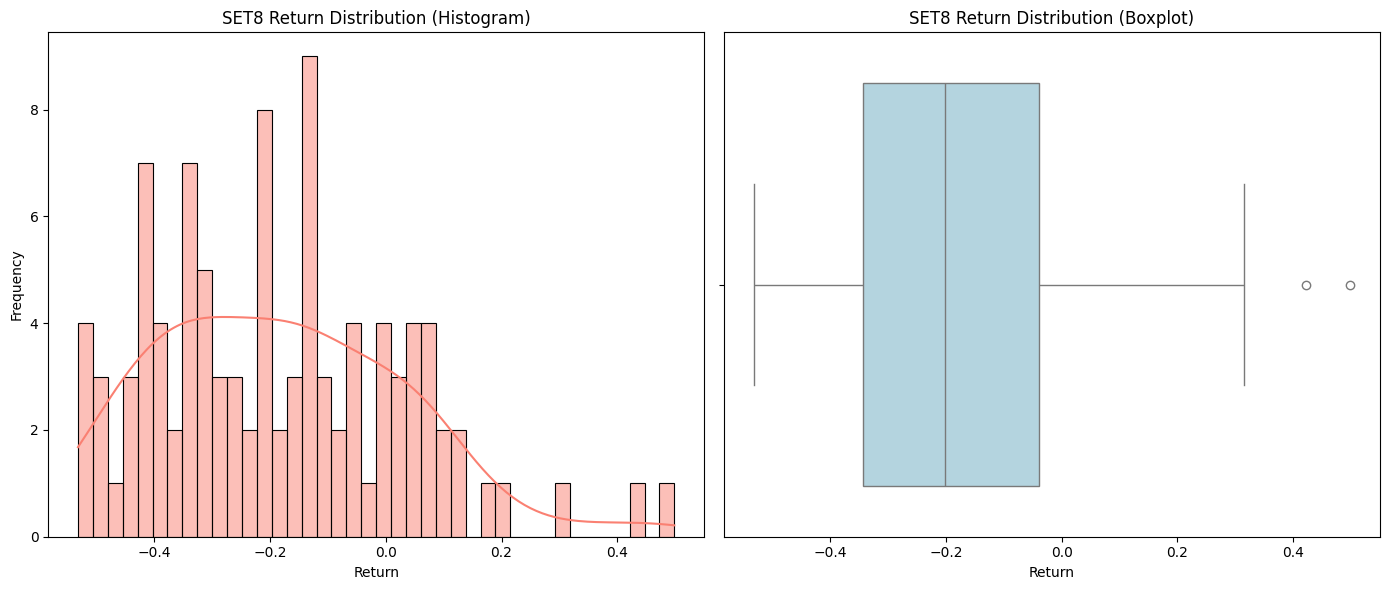

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# SET8 수익률 데이터
set8_returns = adj_returns_df["SET8"].dropna()


# 시각화
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(set8_returns, bins=40, kde=True, color="salmon")
plt.title("SET8 Return Distribution (Histogram)")
plt.xlabel("Return")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.boxplot(x=set8_returns, color="lightblue")
plt.title("SET8 Return Distribution (Boxplot)")
plt.xlabel("Return")

plt.tight_layout()
plt.show()


**왼쪽 히스토그램**
- 분포 모양: 왼쪽으로 치우친 비대칭 분포 (Negative Skew) 형태가 강하게 나타남.

- 평균 < 중앙값: 대체로 음수 영역에 값이 많고, 오른쪽에 드문 양의 이상치가 존재.

- KDE 곡선: 종 모양이 아니라 기울어진 산 모양 → 정규분포 아님.

**오른쪽 박스플랏**
- 중앙값(Median): 음수 쪽에 있음 → 수익률이 평균적으로 낮다는 의미.

- Whiskers & Outliers:

 - 오른쪽 꼬리가 더 길고 이상치도 있음.

 - 극단적인 양의 수익률이 있긴 하지만 빈도는 낮음.

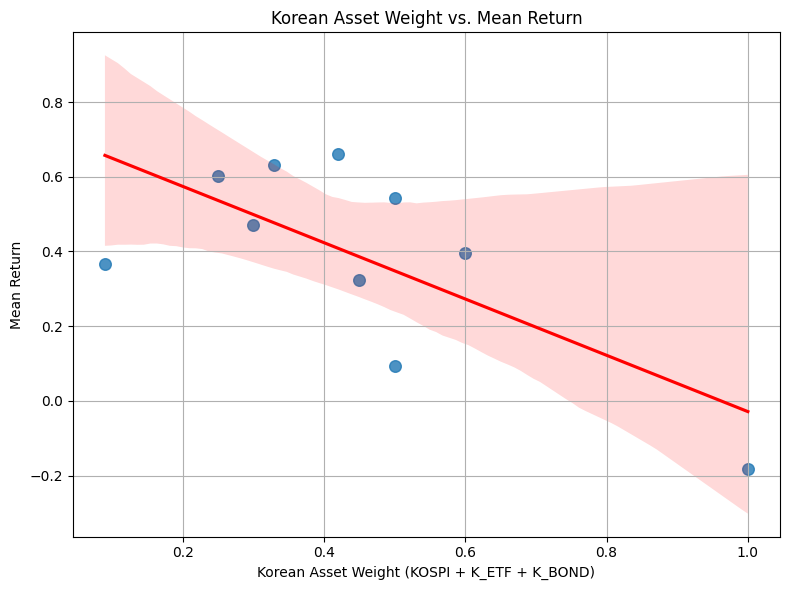

(np.float64(-0.696256451502597), np.float64(0.025309453719977462))

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# 수익률 요약 통계 (Sharpe 계산 결과로부터)
summary_stats = pd.DataFrame({
    'mean': adj_returns_df.mean(),
    'variance': adj_returns_df.var(),
})
summary_stats['sharpe_ratio'] = summary_stats['mean'] / np.sqrt(summary_stats['variance'])

# 각 SET의 한국 자산 비중 (KOSPI + K_ETF + K_BOND)
korea_weights = {
    'SET1': 0.45 + 0.0 + 0.0,
    'SET2': 0.0 + 0.1 + 0.4,
    'SET3': 0.25 + 0.0 + 0.0,
    'SET4': 0.0 + 0.0 + 0.09,
    'SET5': 0.0 + 0.3 + 0.0,
    'SET6': 0.2 + 0.0 + 0.4,
    'SET7': 0.25 + 0.25 + 0.0,
    'SET8': 0.5 + 0.17 + 0.33,
    'SET_9': 0.33 + 0.0 + 0.0,
    'SET_10': 0.14 + 0.28 + 0.0
}

# 데이터 병합
summary_stats['korea_weight'] = pd.Series(korea_weights)

# 산점도 시각화
plt.figure(figsize=(8, 6))
sns.regplot(x='korea_weight', y='mean', data=summary_stats, scatter_kws={'s': 70}, line_kws={"color": "red"})
plt.title('Korean Asset Weight vs. Mean Return')
plt.xlabel('Korean Asset Weight (KOSPI + K_ETF + K_BOND)')
plt.ylabel('Mean Return')
plt.grid(True)
plt.tight_layout()
plt.show()

# 상관계수 계산
corr, p_val = pearsonr(summary_stats['korea_weight'], summary_stats['mean'])

corr, p_val




Mean Return=−0.696⋅(Korean Weight)+0.025 : 회귀식
- 한국 자산 비중이 1.0(100%)일 때는 음의 수익률

- 비중이 낮아질수록 수익률은 상대적으로 증가

- 이 결과는 SET8이 음의 수익률을 기록한 이유를 뒷받침 -> SET8의 한국 자산 비중은 약 1.0에 가까우므로 가장 낮은 수익률을 보인 것.

### 선형 회귀 및 설명력(R², p-value 등)

In [ ]:
import pandas as pd
import statsmodels.api as sm

kospi_ratio = pd.Series(korea_weights)

# 2. 수익률 평균 데이터
summary_stats = pd.DataFrame({
    'mean': {
        'SET1': 0.323377, 'SET2': 0.092564, 'SET3': 0.602890, 'SET4': 0.366233,
        'SET5': 0.470577, 'SET6': 0.396643, 'SET7': 0.543584, 'SET8': -0.183266,
        'SET_9': 0.631253, 'SET_10': 0.660484
    }
})

# 3. 회귀 분석
X = sm.add_constant(kospi_ratio)  # 상수항 추가
y = summary_stats['mean']

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     7.527
Date:                Sun, 22 Jun 2025   Prob (F-statistic):             0.0253
Time:                        16:04:30   Log-Likelihood:                 2.9581
No. Observations:                  10   AIC:                            -1.916
Df Residuals:                       8   BIC:                            -1.311
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7250      0.138      5.271      0.0

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


| 항목             | 해석                                                  |
| -------------- | --------------------------------------------------- |
| **coef (기울기)** | `-0.7535`: 한국 자산 비중이 1 단위 증가할 때 평균 수익률이 약 0.75만큼 감소 |
| **p-value**    | `0.025`: 유의수준 5%보다 작음 → **통계적으로 유의함**               |
| **R-squared**  | `0.485`: 한국 자산 비중이 수익률의 약 48.5%를 설명                 |
| **const (절편)** | `0.725`: 한국 자산 비중이 0일 때 예상 평균 수익률                   |


- 한국 자산 비중이 높을수록 수익률이 유의미하게 감소

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind


# 쌍 구성
random_sets = ["SET1", "SET2", "SET3", "SET_9", "SET_10"]
hold_sets = ["존버_SET1", "존버_SET2", "존버_SET3", "존버_SET9", "존버_SET10"]

results = []

for set_name, hold_name in zip(random_sets, hold_sets):
    try:
        df_random = xlsx.parse(set_name)
        df_hold = xlsx.parse(hold_name)

        r_random = (df_random["total money"] - df_random["labor"]) / df_random["labor"]
        r_hold = (df_hold["total money"] - df_hold["labor"]) / df_hold["labor"]

        t_stat, p_val = ttest_ind(r_random.dropna(), r_hold.dropna(), equal_var=False)

        results.append({
            "SET": set_name,
            "HOLD_SET": hold_name,
            "random_mean": r_random.mean(),
            "hold_mean": r_hold.mean(),
            "t_stat": t_stat,
            "p_value": p_val
        })

    except Exception as e:
        results.append({
            "SET": set_name,
            "HOLD_SET": hold_name,
            "error": str(e)
        })

# 결과 데이터프레임
result_df = pd.DataFrame(results)
print(result_df)


      SET  HOLD_SET  random_mean  hold_mean    t_stat       p_value
0    SET1   존버_SET1     0.323377   0.096619  4.358467  2.344140e-05
1    SET2   존버_SET2     0.092564   0.066723  6.968174  6.996860e-11
2    SET3   존버_SET3     0.602890   0.543787  0.962373  3.377177e-01
3   SET_9   존버_SET9     0.631253   0.335989  6.592879  5.813458e-10
4  SET_10  존버_SET10     0.660484   0.400300  8.174268  7.536111e-14


- t검정으로 두 전략 간 유의미한 차이가 있는지 분석 진행

| 비교쌍                  | 랜덤 평균  | 존버 평균  | p-value      | 해석                  |
| -------------------- | ------ | ------ | ------------ | ------------------- |
| SET1 vs 존버\_SET1     | 0.3234 | 0.0966 | **2.34e-05** | ✅ 유의미한 차이 (랜덤 > 존버) |
| SET2 vs 존버\_SET2     | 0.0926 | 0.0667 | **6.99e-11** | ✅ 유의미한 차이 (랜덤 > 존버) |
| SET3 vs 존버\_SET3     | 0.6029 | 0.5438 | 0.338        | ❌ 유의미하지 않음          |
| SET\_9 vs 존버\_SET9   | 0.6313 | 0.3360 | **5.81e-10** | ✅ 유의미한 차이 (랜덤 > 존버) |
| SET\_10 vs 존버\_SET10 | 0.6605 | 0.4003 | **7.53e-14** | ✅ 유의미한 차이 (랜덤 > 존버) |

- SET3 쌍을 제외하고 모두 p-value < 0.05로, 랜덤 전략이 존버 전략보다 통계적으로 유의미하게 높은 수익률을 보인다